#In order to compare the model, the estimation model was established with the decision tree and linear regression, but the decision tree was based.
#Decision tree error:40876.086956521736
#LinearRegression error: 46682.51356023256

# WEB SCRAPING

In [ ]:
import pandas as pd
import requests
import os
from bs4 import BeautifulSoup
from selenium import webdriver
import subprocess
from datetime import datetime

now = datetime.now().time() # time object

print("now =", now)
print("type(now) =", type(now))	


In [ ]:
links=[]
url="https://www.otoeksper.com.tr/ikinci-el?sayfa="
for i in range(45):
    url_page=url+str(i+1)

    html = requests.get(url_page).content
    encoded_str = html.decode('utf8')
    soup=BeautifulSoup(encoded_str,"lxml")
    for link in soup.findAll('a', {'class': 'Arac-Ozellik Resim'},href=True):
        links.append(('https://www.otoeksper.com.tr'+link['href']))
        
    

In [ ]:
df=pd.DataFrame()

Arac_Ozellikler=['İlan No',
                 'Plaka',
                 'Motor No',
                 'Şase No',
                 'Marka',
                 'Model',
                 'Versiyon',
                 'Model Yılı',
                 'Kilometre',
                 'Yakıt',
                 'Kullanım Şekli',
                 'Vites',
                 'Kasa Tipi',
                 'Motor Hacmi',
                 'Motor Gücü',
                 'Renk',
                 'Tavan',
                 'Kaput',
                 'Sol Ön Çamurluk',
                 'Sağ Ön Çamurluk',
                 'Sol Ön Kapı',
                 'Sağ Ön Kapı',
                 'Sol Arka Kapı',
                 'Sağ Arka Kapı',
                 'Sol Arka Çamurluk',
                 'Sağ Arka Çamurluk',
                 'Bagaj',
                 'Ön Tampon',
                 'Arka Tampon',
                 'Fiyat']
Arac_Database=pd.DataFrame(df,columns=Arac_Ozellikler).dropna()

In [ ]:

def get_data(url):
    driver = webdriver.Firefox(executable_path=r'C:\\Program Files\\Mozilla Firefox\\Driver\\geckodriver.exe')
    driver.get(url)

    page = driver.page_source
    page_soup = BeautifulSoup(page,'html.parser')
    
    table=BeautifulSoup(page,'html.parser').findAll('table')
    genel_ozellikler = pd.read_html(str(table))[3]
    sub_1=list(genel_ozellikler[1])
    
    fiyat = [page_soup.find("span",{"id":"SatisFiyati"}).text]
    containers = page_soup.findAll("div",{"id":"EkspertizYazi"})
    htmlStr = '<table><tbody>'+str(containers[0]).replace('div','tr').replace('span','td')+'</tbody></table>'
    soup = BeautifulSoup(htmlStr, 'html.parser')
    table = soup.find_all('table')
    ekspertiz_ozellikler = pd.read_html(str(table))[0]
    sub_2=list(ekspertiz_ozellikler['Unnamed: 2'])+fiyat


    to_append = sub_1+sub_2

    df_length = len(Arac_Database) 
    print("sub1:",len(sub_1),"sub2:",len(sub_2),now)
    Arac_Database.loc[df_length] = to_append
    os.system("taskkill /f /im firefox.exe")
for z in links:
    get_data(z)


In [ ]:
Arac_Database.to_excel("Database.xlsx") 

# PREDICTION PART with Decision Tree


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn import preprocessing

In [14]:
k = pd.read_excel("TOPSIS_Model.xlsx")

In [15]:
data=k.drop(columns=['İlan No', 'Plaka', 'Şase No', 'Versiyon','Araç Büyüklüğü'])
data = data.drop('Tavan',axis=1)
data = data.drop('Kaput',axis=1)
data = data.drop('Sol Ön Çamurluk',axis=1)
data = data.drop('Sağ Ön Çamurluk',axis=1)
data = data.drop('Sol Ön Kapı',axis=1)
data = data.drop('Sağ Ön Kapı',axis=1)
data = data.drop('Sol Arka Kapı',axis=1)
data = data.drop('Sağ Arka Kapı',axis=1)
data = data.drop('Sol Arka Çamurluk',axis=1)
data = data.drop('Sağ Arka Çamurluk',axis=1)
data = data.drop('Bagaj',axis=1)
data = data.drop('Ön Tampon',axis=1)
data = data.drop('Arka Tampon',axis=1)

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data["Marka ve Model"] = le.fit_transform(data["Marka ve Model"])
data["Yakıt"] = le.fit_transform(data["Yakıt"])
data["Kullanım Şekli"] = le.fit_transform(data["Kullanım Şekli"])
data["Vites"] = le.fit_transform(data["Vites"])
data["Kasa Tipi"] = le.fit_transform(data["Kasa Tipi"])
data["Model Yılı"] = le.fit_transform(data["Model Yılı"])

data

,Marka ve Model,Yakıt,Kullanım Şekli,Vites,Kasa Tipi,Model Yılı,Kilometre,Yakıt Sarfiyatı,Motor Hacmi,Araç Genel Sağlık Puanı,Fiyat
0,29,2,0,0,9,17,203.000,6.5,1.248,6.000000,170000
1,26,2,1,0,4,16,198.000,5.7,1.248,5.923077,148000
2,29,2,0,0,9,16,119.000,6.5,1.248,6.230769,165000
3,73,2,1,0,6,13,70.155,5.2,1.398,7.000000,166000
4,61,0,0,1,2,19,24.500,4.4,1.198,6.384615,278000
...,...,...,...,...,...,...,...,...,...,...,...
796,22,0,1,0,4,12,302.819,6.1,1.598,5.692308,90000
797,26,2,1,0,4,19,41.410,5.7,1.248,6.615385,197500
798,28,1,0,0,1,8,180.000,5.2,1.368,5.384615,82500
799,53,2,2,1,7,15,160.000,19.4,2.987,7.000000,795000


In [18]:
X = data.drop('Fiyat',axis=1)
y = data['Fiyat']

In [19]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
sc_data = sc.fit_transform(X)
sc_data = pd.DataFrame(sc_data)
sc_data.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.423439,0.889162,-0.483566,-0.487875,0.814450,-0.616466,1.392556,0.498376,-0.775990,-0.944306
1,-0.542685,0.889162,0.852076,-0.487875,-0.926144,-0.872581,1.334644,-0.100910,-0.775990,-1.062142
2,-0.423439,0.889162,-0.483566,-0.487875,0.814450,-0.872581,0.419649,0.498376,-0.775990,-0.590798
3,1.325499,0.889162,0.852076,-0.487875,-0.229906,-1.640926,-0.146085,-0.475463,0.082925,0.587562
4,0.848516,-1.169274,-0.483566,2.049707,-1.622381,-0.104237,-0.674872,-1.074749,-1.062295,-0.355126


In [20]:
data.isnull().sum()

Marka ve Model             0
Yakıt                      0
Kullanım Şekli             0
Vites                      0
Kasa Tipi                  0
Model Yılı                 0
Kilometre                  0
Yakıt Sarfiyatı            0
Motor Hacmi                0
Araç Genel Sağlık Puanı    0
Fiyat                      0
dtype: int64

In [21]:
# Perform train-test spliting
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(sc_data,y, test_size = 0.2)

In [22]:
from sklearn.tree import DecisionTreeRegressor
dt_model = DecisionTreeRegressor()
dt_model.fit(xtrain, ytrain)
pred = dt_model.predict(xtest)
dt_pred = pd.DataFrame(pred)
dt_pred.head()

,0
0,150000.0
1,271500.0
2,182500.0
3,259900.0
4,218000.0


In [23]:
from sklearn.metrics import mean_absolute_error
error = mean_absolute_error(ytest, dt_pred)

In [25]:
error

40876.086956521736

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0, 0.5, 'Predicted Price')

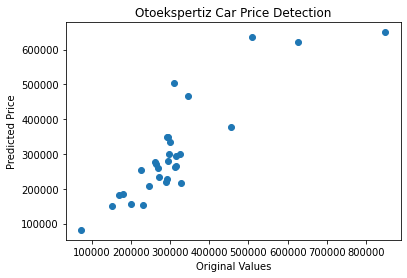

In [28]:
plt.scatter(x = ytest.head(30), y = dt_pred.head(30))
plt.title("Otoekspertiz Car Price Detection")
plt.xlabel("Original Values")
plt.ylabel("Predicted Price")

In [29]:
def get_mse(no_leaf_nodes, x_train, x_test, y_train, y_test):
    model = DecisionTreeRegressor(min_samples_leaf= no_leaf_nodes, random_state = 1)
    model.fit(x_train, ytrain)
    pred = model.predict(xtest)
    df_pred = pd.DataFrame(pred)
    mse = mean_absolute_error(ytest,pred)
    return mse,


In [30]:

candidate_max_leaf_nodes = [5, 25, 50, 100, 250, 500, 1000]
scores=9999999
scores1=0
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for i in candidate_max_leaf_nodes:
    scores1 = get_mse(i,xtrain, xtest, ytrain, ytest)
    if(scores1[-1]<10000009):
        scores = scores1
        max_leaf_nodes = i
    print("MAE: ",scores,"No. of Nodes: ",i)
        
print("MAE Final: ",scores,"No. of Nodes: ",max_leaf_nodes)
# Store the best value of max_leaf_nodes (it will be either 5, 25, 50, 100, 250 or 500)
best_tree_size = max_leaf_nodes
#xtrain, xtest, ytrain, ytest

MAE:  (38726.37360741398,) No. of Nodes:  5
MAE:  (43862.825774352365,) No. of Nodes:  25
MAE:  (49467.69774564767,) No. of Nodes:  50
MAE:  (51226.939429926504,) No. of Nodes:  100
MAE:  (67570.0435677124,) No. of Nodes:  250
MAE:  (76687.890625,) No. of Nodes:  500
MAE:  (76687.890625,) No. of Nodes:  1000
MAE Final:  (76687.890625,) No. of Nodes:  1000


In [31]:
from sklearn.tree import DecisionTreeRegressor
dt2_model = DecisionTreeRegressor(max_leaf_nodes=500)

In [32]:
dt2_model.fit(xtrain, ytrain)

DecisionTreeRegressor(max_leaf_nodes=500)

In [42]:
# Single Model Price Prediction
a='29	2	0	0	9	17	203.000	6.5	1.248	7'
a=a.replace('\t',",").split(",")
a

['29', '2', '0', '0', '9', '17', '203.000', '6.5', '1.248', '7']

In [44]:
pred2 = dt2_model.predict(np.array(a).reshape(1,10))

In [45]:
dt_pred2 = pd.DataFrame(pred2)

In [47]:
dt_pred2.head()
#Predicted Price Value

,0
0,220000.0


# PREDICTION PART with Linear Regression


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_absolute_error



dataset = pd.read_excel("TOPSIS_Model.xlsx")
dataset = dataset.drop('Şase No',axis=1)
dataset = dataset.drop('Versiyon',axis=1)
dataset = dataset.drop('Marka ve Model',axis=1)
dataset = dataset.drop('Tavan',axis=1)
dataset = dataset.drop('Kaput',axis=1)
dataset = dataset.drop('Sol Ön Çamurluk',axis=1)
dataset = dataset.drop('Sağ Ön Çamurluk',axis=1)
dataset = dataset.drop('Sol Ön Kapı',axis=1)
dataset = dataset.drop('Sağ Ön Kapı',axis=1)
dataset = dataset.drop('Sol Arka Kapı',axis=1)
dataset = dataset.drop('Sağ Arka Kapı',axis=1)
dataset = dataset.drop('Sol Arka Çamurluk',axis=1)
dataset = dataset.drop('Sağ Arka Çamurluk',axis=1)
dataset = dataset.drop('Bagaj',axis=1)
dataset = dataset.drop('Ön Tampon',axis=1)
dataset = dataset.drop('Arka Tampon',axis=1)
dataset_copy = dataset.copy()
dataset = dataset.drop('Plaka',axis=1)
dataset = dataset.drop('İlan No',axis=1)

dataset["Model Yaşı"] = 2022-dataset["Model Yılı"]
dataset = dataset.drop('Model Yılı',axis=1)

dataset

,Yakıt,Kullanım Şekli,Vites,Kasa Tipi,Kilometre,Yakıt Sarfiyatı,Araç Büyüklüğü,Motor Hacmi,Araç Genel Sağlık Puanı,Fiyat,Model Yaşı
0,Dizel,Binek,Düz,Sedan,203.000,6.5,1,1.248,6.000000,170000,7
1,Dizel,Hafif Ticari,Düz,Kamyonet/2,198.000,5.7,3,1.248,5.923077,148000,8
2,Dizel,Binek,Düz,Sedan,119.000,6.5,1,1.248,6.230769,165000,8
3,Dizel,Hafif Ticari,Düz,Panelvan,70.155,5.2,3,1.398,7.000000,166000,11
4,Benzinli,Binek,Otomatik,Hatcback 5 Kapı,24.500,4.4,1,1.198,6.384615,278000,5
...,...,...,...,...,...,...,...,...,...,...,...
796,Benzinli,Hafif Ticari,Düz,Kamyonet/2,302.819,6.1,3,1.598,5.692308,90000,12
797,Dizel,Hafif Ticari,Düz,Kamyonet/2,41.410,5.7,3,1.248,6.615385,197500,5
798,Benzinli/LPG,Binek,Düz,Hatcback 3 Kapı,180.000,5.2,1,1.368,5.384615,82500,16
799,Dizel,SUV / 4x4,Otomatik,Pick-Up,160.000,19.4,2,2.987,7.000000,795000,9


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dataset["Yakıt"] = le.fit_transform(dataset["Yakıt"])
dataset["Kullanım Şekli"] = le.fit_transform(dataset["Kullanım Şekli"])
dataset["Vites"] = le.fit_transform(dataset["Vites"])
dataset["Kasa Tipi"] = le.fit_transform(dataset["Kasa Tipi"])
dataset

,Yakıt,Kullanım Şekli,Vites,Kasa Tipi,Kilometre,Yakıt Sarfiyatı,Araç Büyüklüğü,Motor Hacmi,Araç Genel Sağlık Puanı,Fiyat,Model Yaşı
0,2,0,0,9,203.000,6.5,1,1.248,6.000000,170000,7
1,2,1,0,4,198.000,5.7,3,1.248,5.923077,148000,8
2,2,0,0,9,119.000,6.5,1,1.248,6.230769,165000,8
3,2,1,0,6,70.155,5.2,3,1.398,7.000000,166000,11
4,0,0,1,2,24.500,4.4,1,1.198,6.384615,278000,5
...,...,...,...,...,...,...,...,...,...,...,...
796,0,1,0,4,302.819,6.1,3,1.598,5.692308,90000,12
797,2,1,0,4,41.410,5.7,3,1.248,6.615385,197500,5
798,1,0,0,1,180.000,5.2,1,1.368,5.384615,82500,16
799,2,2,1,7,160.000,19.4,2,2.987,7.000000,795000,9


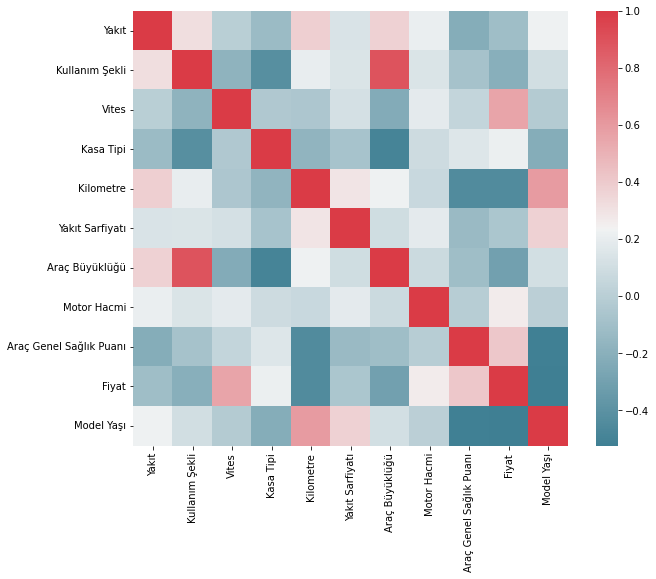

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)


In [ ]:
y = dataset["Fiyat"].to_numpy()
dataset = dataset.drop(columns = ["Fiyat"])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing 

x = dataset.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_new = pd.DataFrame(x_scaled)
columns = dataset.columns 

In [ ]:
X = dataset.to_numpy()
X

array([[ 2.        ,  0.        ,  0.        , ...,  1.248     ,
         6.        ,  7.        ],
       [ 2.        ,  1.        ,  0.        , ...,  1.248     ,
         5.92307692,  8.        ],
       [ 2.        ,  0.        ,  0.        , ...,  1.248     ,
         6.23076923,  8.        ],
       ...,
       [ 1.        ,  0.        ,  0.        , ...,  1.368     ,
         5.38461538, 16.        ],
       [ 2.        ,  2.        ,  1.        , ...,  2.987     ,
         7.        ,  9.        ],
       [ 2.        ,  1.        ,  0.        , ...,  1.398     ,
         5.69230769, 10.        ]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.75, test_size = 0.25, random_state = 1)

In [ ]:
lm = LinearRegression(fit_intercept=True, normalize = True, copy_X=True)
lm.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


LinearRegression(normalize=True)

In [ ]:
prediction = lm.predict(X_test)


In [ ]:
dataset_prediction = pd.DataFrame(prediction)
print(dataset_prediction)

                 0
0    175426.517666
1    197462.805808
2    316532.796988
3    243968.243879
4    383615.423921
..             ...
196  316276.412952
197  277651.148114
198  304343.435356
199  317712.848842
200  313570.969471

[201 rows x 1 columns]


Text(0, 0.5, 'Predicted Price')

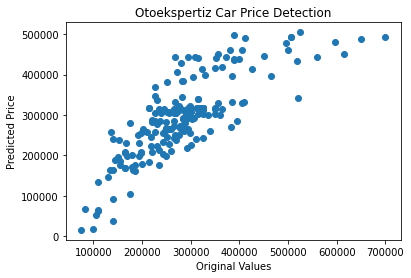

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(x = y_test, y = dataset_prediction)
plt.title("Otoekspertiz Car Price Detection")
plt.xlabel("Original Values")
plt.ylabel("Predicted Price")

In [ ]:
print(mean_absolute_error(y_test, prediction))

46682.51356023256


In [ ]:
dataset_prediction

,0
0,175426.517666
1,197462.805808
2,316532.796988
3,243968.243879
4,383615.423921
...,...
196,316276.412952
197,277651.148114
198,304343.435356
199,317712.848842


In [ ]:
pred2 = lm.predict(X)

In [ ]:
dataset_copy["Predicted Price"]=pd.DataFrame(pred2)

In [ ]:
dataset_copy.to_excel("Output.xlsx")

# TOPSIS PART

In [ ]:
import pandas as pd

dataset = pd.read_excel("C:\TOPSIS_Data.xlsx")
dataset = dataset.drop('Şase No',axis=1)
dataset = dataset.drop('Versiyon',axis=1)
dataset = dataset.drop('Marka ve Model',axis=1)
dataset = dataset.drop('İlan No',axis=1)

dataset["Model Yaşı"] = 2022-dataset["Model Yılı"]
dataset = dataset.drop('Model Yılı',axis=1)

dataset

,Plaka,Kilometre,Yakıt Sarfiyatı,Araç Büyüklüğü,Motor Hacmi,Fiyat,Araç Genel Sağlık Puanı,Model Yaşı
0,38 GA 907,43445,5.8,1,1199.00,281950,6.181818,8
1,06 FB 8873,105899,4.8,1,999.00,201950,7.000000,9
2,16 LCR 76,56755,4.8,1,1199.00,226950,7.000000,6
3,34 LL 2025,84632,6.5,1,1.56,350950,7.000000,8
4,50 BG 339,56819,6.5,1,1199.00,495950,5.545455,5
...,...,...,...,...,...,...,...,...
799,34 EEE 574,16979,6.9,1,1368.00,302000,5.727273,1
800,34 EEC 096,13038,6.9,1,1368.00,298500,6.545455,1
801,34 EEC 502,16510,6.9,1,1368.00,298500,2.727273,1
802,34 EAU 001,8584,6.9,1,1368.00,325000,7.000000,1


In [ ]:
def Normalize(data, nCol, weights):
    for i in range(1, nCol):
        temp = 0
        # Calculating Root of Sum of squares of a particular column
        for j in range(len(data)):
            temp = temp + data.iloc[j, i]**2
        temp = temp**0.5
        # Weighted Normalizing a element
        for j in range(len(data)):
            data.iat[j, i] = (data.iloc[j,i]/temp)*weights[i-1]
    return data

In [ ]:
def Calc_Values(data, nCol, impact):
    p_sln = (data.max().values)[1:]
    n_sln = (data.min().values)[1:]
    for i in range(0, nCol):
        if impact[i-1] == '-':
            p_sln[i-1], n_sln[i-1] = n_sln[i-1], p_sln[i-1]
    return p_sln, n_sln

In [ ]:
temp_dataset=dataset.copy()
impact=('-','-','+','+','-','+','-')
nCol=7

a,b,c,d,e,f,g = input("Enter importance weights between 1 and 5 for Kilometre, Yakıt Sarfiyatı, Araç Büyüklüğü, Motor Hacmi, Fiyat, Araç Genel Sağlık Puanı, Model Yaşı: ").split()
weights=[int(a),int(b),int(c),int(d),int(e),int(f),int(g)]
weights

Enter importance weights between 1 and 5 for Kilometre, Yakıt Sarfiyatı, Araç Büyüklüğü, Motor Hacmi, Fiyat, Araç Genel Sağlık Puanı, Model Yaşı: 5 2 1 1 5 2 4


[5, 2, 1, 1, 5, 2, 4]

In [ ]:
temp_dataset=Normalize(temp_dataset, nCol, weights)
temp_dataset

,Plaka,Kilometre,Yakıt Sarfiyatı,Araç Büyüklüğü,Motor Hacmi,Fiyat,Araç Genel Sağlık Puanı,Model Yaşı
0,38 GA 907,0.065298,0.067875,0.019803,0.031189,0.166557,0.066761,8
1,06 FB 8873,0.159166,0.056172,0.019803,0.025987,0.119298,0.075597,9
2,16 LCR 76,0.085303,0.056172,0.019803,0.031189,0.134067,0.075597,6
3,34 LL 2025,0.127202,0.076066,0.019803,0.000041,0.207318,0.075597,8
4,50 BG 339,0.085399,0.076066,0.019803,0.031189,0.292974,0.059888,5
...,...,...,...,...,...,...,...,...
799,34 EEE 574,0.025519,0.080747,0.019803,0.035585,0.178401,0.061852,1
800,34 EEC 096,0.019596,0.080747,0.019803,0.035585,0.176334,0.070688,1
801,34 EEC 502,0.024815,0.080747,0.019803,0.035585,0.176334,0.029453,1
802,34 EAU 001,0.012902,0.080747,0.019803,0.035585,0.191988,0.075597,1


In [ ]:
# Calculating positive and negative values
p_sln, n_sln = Calc_Values(temp_dataset, nCol, impact)

# calculating topsis score
score = [] # Topsis score
pp = [] # distance posit1ive
nn = [] # distance negative
 
# Calculating distances and Topsis score for each row
for i in range(len(temp_dataset)):
    temp_p, temp_n = 0, 0
    for j in range(1, nCol):
        temp_p = temp_p + (p_sln[j-1] - temp_dataset.iloc[i, j])**2
        temp_n = temp_n + (n_sln[j-1] - temp_dataset.iloc[i, j])**2
    temp_p, temp_n = temp_p**0.5, temp_n**0.5
    score.append(temp_n/(temp_p + temp_n))
    nn.append(temp_n)
    pp.append(temp_p)
    
# Appending new columns in dataset   
rank_dataset=dataset.copy()
rank_dataset['Distance Positive'] = pp
rank_dataset['Distance negative'] = nn
rank_dataset['Topsis Score'] = score
 
# calculating the rank according to topsis score
rank_dataset['Rank'] = (rank_dataset['Topsis Score'].rank(method='max', ascending=False))
rank_dataset = rank_dataset.sort_values(['Rank'])
rank_dataset

,Plaka,Kilometre,Yakıt Sarfiyatı,Araç Büyüklüğü,Motor Hacmi,Fiyat,Araç Genel Sağlık Puanı,Model Yaşı,Distance Positive,Distance negative,Topsis Score,Rank
228,35 RN 125,32172,6.6,1,1368.0,100000,7.000000,27,0.100939,1.418178,0.933554,1.0
230,20 AEV 156,3122,5.2,4,1598.0,213950,6.272727,2,0.113281,1.434755,0.926823,2.0
231,20 AEV 971,3089,5.2,4,1598.0,213950,5.909091,2,0.113618,1.434653,0.926616,3.0
563,34 ESJ 876,4,5.7,3,1368.0,208500,6.545455,1,0.114843,1.438860,0.926084,4.0
571,38 AFF 612,8297,5.7,3,1368.0,207950,6.545455,1,0.115229,1.427481,0.925307,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72,34 BPS 366,335950,6.5,1,1461.0,425950,4.363636,4,0.561429,0.927057,0.622819,800.0
33,22 FR 792,475000,6.0,1,1248.0,72000,6.454545,18,0.718632,0.878360,0.550009,801.0
614,48 KC 460,500000,17.6,4,1461.0,35000,7.000000,24,0.769676,0.856827,0.526791,803.0
615,48 U 7813,500000,17.6,4,1461.0,35000,7.000000,22,0.769676,0.856827,0.526791,803.0


In [ ]:
rank_dataset.to_excel("Topsis_Output.xlsx")